In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import random

from tabulate import tabulate

import performance
import yfinance as yf

### Barchart Chart of the Day Out of Sample Testing
**Barchart is a data provider for market news, stock quotes, and many other financial information.** In this project, we test Barchart's Chart of the Day feature with out of sample data and see how their "alpha" decays over time. Note that Chart of the Day is a newsletter style feature that is being offered daily to subscribers for free, with potential medium term investment opportunities. 

**A typical Chart of the Day article looks like the snippet below.** (source: https://www.barchart.com/story/news/17589238/chart-of-the-day-protagonist-therapeutics-wide-opinions) As a subscriber, you will get a one-pager like this on every trading day, suggesting a stock picked by Barchart's analysts. Note that a typical sentence at the end of first paragraph of each article always goes like this: "Since the Trend Seeker signaled a buy on xx date the stock gained yy %", and it is generally a sizable return. Since we don't have premium access to know exactly how their signals work (or at least I have not found a simple way to decode their Trend Seeker signals), I thought it might be interesting to see how these stocks are performing once they are mentioned in Barchart's Chart of the Day feature.

**Chart of the Day feature seems to have started the daily posts since Nov 22nd, 2022.** This should give us enough sample size to evaluate the post-mortem performance, given its almost 8 months history. 

**The main takeaways of this project are:**
- Barchart's Chart of the Day feature has a decent amount of alpha between the signal date and the published date.
- However, once this information is published on their website, the alpha no longer seems to exist, or at least not as strong. This proves that Barchart seems to be pretty good at finding signals and optimal exit conditions.
- One caveat is that without knowing the full size of their signals, we have no idea how robust this "Trend Seeker" signal is. In other words, we are only given the stocks that strongly performed under their signals, but not the stocks that underperformed (as we don't actually know how many stocks were qualified under their signals, and only the ones that outperformed were published on the website).
- We also observe that although the alpha decays very quickly after publishment, the degree of such decay varies across sectors. Notably, technology and industrials sectors tend to keep performing even after publishment.
- We offer a simple trading strategy where we invest stocks mentioned by Chart of the Day on the day of their corresponding articles, if and only if they are in tech or industrials sectors. We hold such stocks for 30 days after publishment. This strategy outperformed the S&P500 index during the available period, and offers a slightly better risk-adjusted return. 

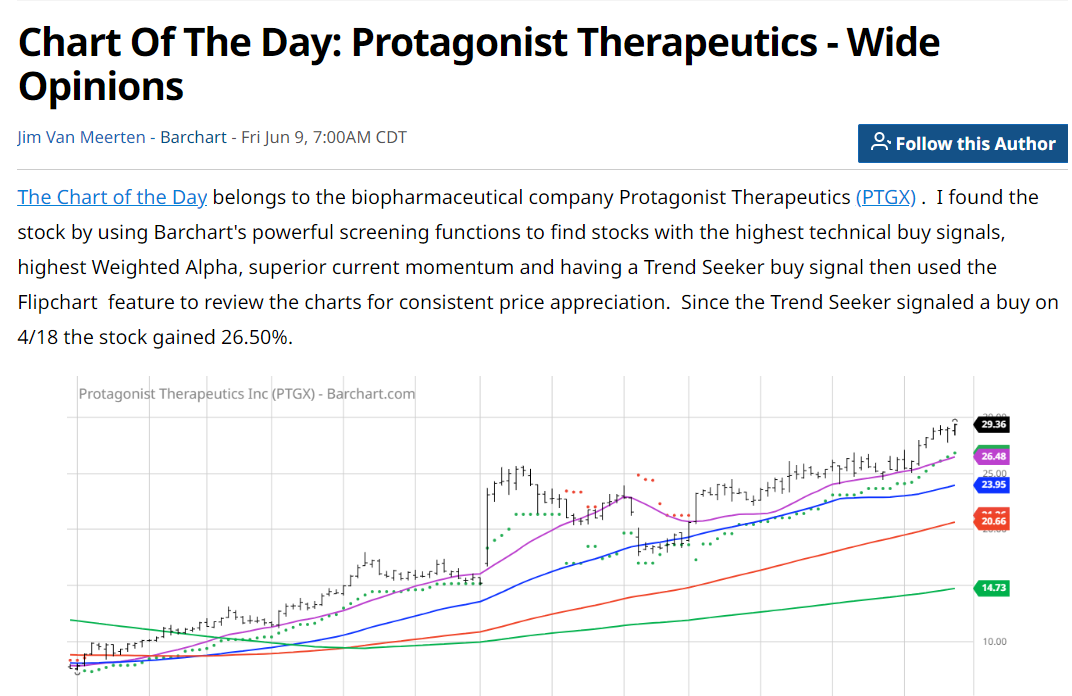

In [2]:
from IPython import display
display.Image('Barchart Picture.png',width=600,height=300)

### Underlying Data
**I keep a tab of a running list of stocks mentioned in Chart of the Day, and will continue to update this track record on a weekly basis.** The relevant information is also displayed in the data frame below, such as the article published date as well as the signal date mentioned in the article.

In [3]:
chart_of_the_day = pd.read_csv('./data/Chart of the Day Info.csv')
chart_of_the_day.head(10)

,Published Date,Signal Date,Ticker
0,2022-11-22,2022-10-11,EME
1,2022-11-23,2022-10-24,THR
2,2022-11-30,2022-11-29,AXSM
3,2022-12-01,2022-11-30,CPB
4,2022-12-02,2022-12-01,HURN
5,2022-12-05,2022-12-02,BBW
6,2022-12-06,2022-12-05,HRMY
7,2022-12-06,2022-11-07,PG
8,2022-12-07,2022-11-08,PM
9,2022-12-08,2022-10-25,TIPT


**We share a quick look at the sector breakdown of selected stocks.** The majority come from the following four segments: Consumer Cyclical, Technology, Healthcare, and Industrials.

**The choice of stocks from Barchart's feature is also an interesting one.** For example, Mexican poultry producer Industrias Bachoco (Ticker: IBA) was featured on Mar 7th, 2023 (signal generation on Jan 11th, 2023). But it's not difficult to find out that this company has since been delisted from NYSE on Apr 24th. As another example, CPB and MSFT each has been featured twice. In this case, we treat each occurrance as an individual observation.

In [4]:
sector_df = pd.read_csv('./data/Chart of the Day Sector Data.csv')
sector_df.groupby('Sector')['Ticker'].nunique().sort_values()

Sector
Others                     1
Utilities                  2
Communication Services     3
Energy                     4
Basic Materials            5
Financial Services        10
Consumer Defensive        13
Industrials               19
Healthcare                22
Technology                23
Consumer Cyclical         26
Name: Ticker, dtype: int64

### Backtesting

**Based on the information above, we can test the performance of each aforementioned stock in the following three time period:**
- Performance over the past 3 months (if available) before the signal generation date;
- Performance between the signal generation date and published date;
- Performance over the next 6 months (if available) after the published date.

In [5]:
# Adjusting for duplicate mentions of the same stock. Running list: CPB, MSFT.
chart_of_the_day.iloc[12,2] = 'CPB.2'
chart_of_the_day.iloc[129,2] = 'MSFT.2'

# Stock Price
price_df = pd.read_csv('./data/Chart of the Day Daily Data.csv')
price_df_pivot = price_df.loc[price_df['Type']=='Adj Close'].pivot_table(index='Date',columns='Ticker',values='Price')
ret_df = price_df_pivot.pct_change().dropna(how='all')

# Adjusting for duplicate mentions of the same stock. Running list: CPB, MSFT.
ret_df['CPB.2'] = ret_df['CPB'].copy()
ret_df['MSFT.2'] = ret_df['MSFT'].copy()
ret_df = ret_df.stack().reset_index()
ret_df.rename({0:'Return'},axis=1,inplace=True)
ret_df.head(5)

,Date,Ticker,Return
0,2022-03-10,ACAD,-0.047324
1,2022-03-10,ACGL,-0.007902
2,2022-03-10,ACLS,-0.013084
3,2022-03-10,AGM,-0.001163
4,2022-03-10,AIR,-0.001542


In [6]:
# Before Signal, Between Signal and Publish, After Publish labels
ret_df_label = ret_df.copy()

for i in ret_df_label['Ticker'].unique():
    signal_date_i = chart_of_the_day.loc[chart_of_the_day['Ticker']==i,'Signal Date'].values[0]
    publish_date_i = chart_of_the_day.loc[chart_of_the_day['Ticker']==i,'Published Date'].values[0]
    
    prior_signal_condition = (ret_df_label['Ticker']==i)&(ret_df_label['Date']<=signal_date_i)
    after_signal_condition = (ret_df_label['Ticker']==i)&(ret_df_label['Date']>signal_date_i)
    signal_publish_condition = (ret_df_label['Ticker']==i)&(ret_df_label['Date']>signal_date_i)&(ret_df_label['Date']<=publish_date_i)
    prior_publish_condition = (ret_df_label['Ticker']==i)&(ret_df_label['Date']<=publish_date_i)
    after_publish_condition = (ret_df_label['Ticker']==i)&(ret_df_label['Date']>publish_date_i)
    
    ret_df_label.loc[prior_signal_condition,'Type'] = 'Prior to Signal'
    ret_df_label.loc[signal_publish_condition,'Type'] = 'Between Signal and Publishing'
    ret_df_label.loc[after_publish_condition,'Type'] = 'After Publishing'
    
    ret_df_label.loc[prior_signal_condition,'Days After Signal'] = np.arange(-prior_signal_condition.sum()+1,1) 
    ret_df_label.loc[after_signal_condition,'Days After Signal'] = np.arange(1,after_signal_condition.sum()+1)
    
    ret_df_label.loc[prior_publish_condition,'Days After Publish'] = np.arange(-prior_publish_condition.sum()+1,1) 
    ret_df_label.loc[after_publish_condition,'Days After Publish'] = np.arange(1,after_publish_condition.sum()+1)

ret_df_label['Days After Signal'] = ret_df_label['Days After Signal'].astype(int)
ret_df_label['Days After Publish'] = ret_df_label['Days After Publish'].astype(int)

ret_df_label.head(10)

,Date,Ticker,Return,Type,Days After Signal,Days After Publish
0,2022-03-10,ACAD,-0.047324,Prior to Signal,-273,-300
1,2022-03-10,ACGL,-0.007902,Prior to Signal,-144,-203
2,2022-03-10,ACLS,-0.013084,Prior to Signal,-198,-216
3,2022-03-10,AGM,-0.001163,Prior to Signal,-211,-245
4,2022-03-10,AIR,-0.001542,Prior to Signal,-211,-241
5,2022-03-10,ALDX,-0.023202,Prior to Signal,-255,-272
6,2022-03-10,ALGM,-0.017222,Prior to Signal,-211,-231
7,2022-03-10,ALTR,-0.027269,Prior to Signal,-211,-266
8,2022-03-10,ANET,0.002487,Prior to Signal,-225,-254
9,2022-03-10,ARDX,-0.008448,Prior to Signal,-176,-204


### Performance Result
#### a. Single Stocks

**We plot the cumulative returns of those three periods for each stock.** Specifically, we use color gray to represent the PnL before the signal, orange for PnL during signal and publish date, ad navy for PnL after the publish date. The graph below plots 20 stocks featured in Chart of the Day as an example. 

**It is not difficult to notice that there are some sizable returns between Signal and Publishing, whereas the returns are sort of random once the stock selection was published.** In some cases, there is even a large drop in stock prices. 

In [7]:
# We sample 120 days for both before signal and after publish to make sure we are looking at different stocks in the same lens. 
ret_df_label_plot1 = ret_df_label.loc[(ret_df_label['Days After Signal']>=-60)&(ret_df_label['Days After Signal']<=120)].copy()
ret_df_label_plot1['PnL'] = ret_df_label_plot1.groupby('Ticker')['Return'].cumsum()
ret_df_label_plot1.head(5)

,Date,Ticker,Return,Type,Days After Signal,Days After Publish,PnL
8638,2022-06-14,INTA,-0.051282,Prior to Signal,-60,-166,-0.051282
8768,2022-06-15,INTA,-0.007432,Prior to Signal,-59,-165,-0.058715
8898,2022-06-16,INTA,-0.054459,Prior to Signal,-58,-164,-0.113173
9028,2022-06-17,INTA,0.004320,Prior to Signal,-57,-163,-0.108854
9158,2022-06-21,INTA,-0.009319,Prior to Signal,-56,-162,-0.118173


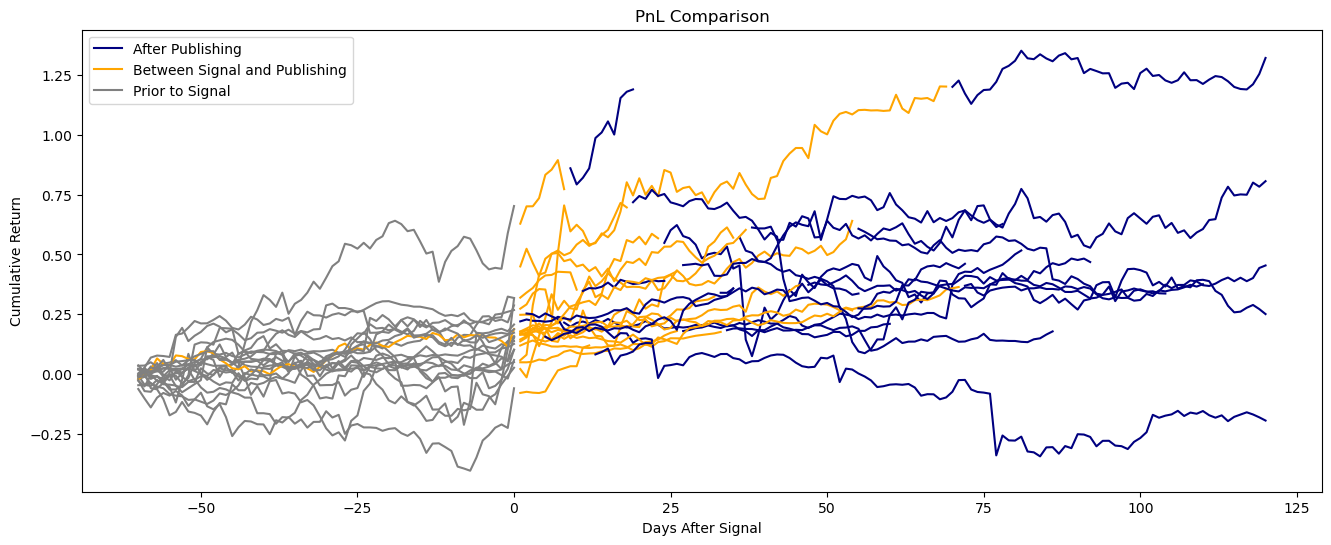

In [8]:
fig,ax=plt.subplots(figsize=(16,6))

for i in pd.Series(ret_df_label_plot1['Ticker'].unique()).sample(20):
    ret_df_label_plot1.loc[ret_df_label_plot1['Ticker']==i].pivot_table(index='Days After Signal',columns='Type',values='PnL').plot(ax=ax,color=['navy','orange','gray'])

ax.legend(['After Publishing','Between Signal and Publishing','Prior to Signal'])
plt.title('PnL Comparison')
plt.ylabel('Cumulative Return')
plt.show()

#### b. Portfolio
**We consolidate the above chart into one single line to represent the overall performance of the signal before and after publishment.** Here, we re-adjust the x axis to "Days After Publish". Note that the average number of trading days between signal and publish is around 28 days.

**It is easy to see that the Trend Seeker signal, as the name suggests, is a trend following strategy.** The dashed red line is the average signal start date for stocks mentioned in Chart of the Day articles (as of published date), and returns after the dashed gray line are the true average out of sample returns for the same set of stocks. **We observe that this signal picks up stocks that relatively performed well over a certain period of time (day -120 ~ day -28), generates a buy signal for these stocks, and hold until the publish date (which could mean that there is an exit signal, and that is why Barchart felt safe to disclose this alpha).** During the holding period, this signal generates a decent amount of positive returns in short term (~28 days), and we can see that this return is much more generous than it is before the buy signal. This conclusion is drawn from the fact that the slope of the PnL between red dashed line and gray dashed line is steeper than the slope of the PnL before red dashed line.

In [9]:
print('Avg Holding Period:',
      round(ret_df_label.loc[ret_df_label['Type']=='Between Signal and Publishing'].groupby('Ticker')['Return'].count().mean(),1),
     'Days')

Avg Holding Period: 28.1 Days


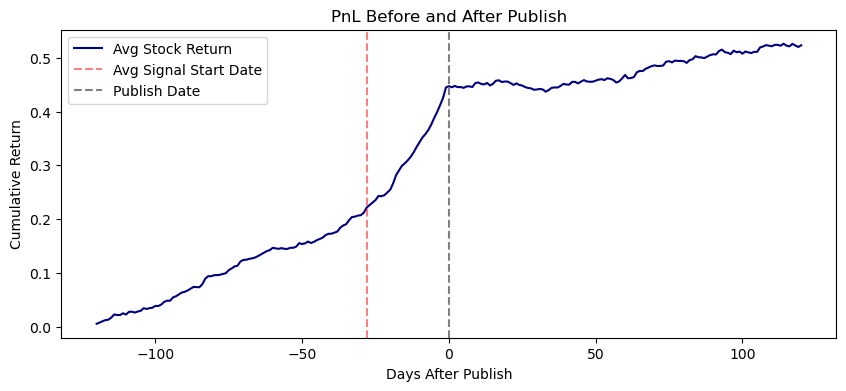

In [10]:
ret_df_label_plot2 = ret_df_label.loc[(ret_df_label['Days After Publish']>=-120)&(ret_df_label['Days After Publish']<=120)].copy()

fig,ax=plt.subplots(figsize=(10,4))
ret_df_label_plot2.groupby('Days After Publish')['Return'].mean().cumsum().plot(ax=ax,label='Avg Stock Return',color='navy')
plt.axvline(x=-28,color='red',label='Avg Signal Start Date',linestyle='--',alpha=0.5)
plt.axvline(x=0,color='gray',label='Publish Date',linestyle='--')

plt.title('PnL Before and After Publish')
plt.legend()
plt.ylabel('Cumulative Return')
plt.show()

#### C. Sectors
**We perform the same exercise above, but add a sector breakdown.** The distribution of stocks in different sectors can be found in previous section. We plot the six most mentioned sectors and see if there is a significant difference across sectors. Each of these sectors has at least 10 stocks featured in Barchart's articles. These six sectors and their associated number of stocks featured are shown in the table below.

In [11]:
ret_df_label_plot3 = ret_df_label.merge(sector_df,how='left',on='Ticker')
ret_df_label_plot3 = ret_df_label_plot3.loc[(ret_df_label_plot3['Days After Publish']>=-120)&
                                            (ret_df_label_plot3['Days After Publish']<=120)]
ret_df_label_plot3 = ret_df_label_plot3.loc[ret_df_label_plot3['Sector'].isin(['Consumer Cyclical',
                                                                               'Technology',
                                                                               'Healthcare',
                                                                               'Industrials',
                                                                               'Consumer Defensive',
                                                                               'Financial Services'])]
print_df = ret_df_label_plot3.loc[ret_df_label_plot3['Type']=='Between Signal and Publishing'
                            ].groupby(['Sector','Ticker'])['Return'].count().unstack().mean(axis=1).round(1).reset_index()
print_df = print_df.merge(ret_df_label_plot3.groupby('Sector')['Ticker'].nunique(),left_on='Sector',right_index=True)
print_df.columns = ['Sector','Avg Holding Period','Number of Stocks']

print(tabulate(print_df.sort_values('Number of Stocks'),headers=print_df.columns,showindex=False,numalign='center'))

Sector               Avg Holding Period    Number of Stocks
------------------  --------------------  ------------------
Financial Services          30.8                  10
Consumer Defensive          25.4                  13
Industrials                 26.6                  19
Healthcare                  31.8                  22
Technology                  33.3                  23
Consumer Cyclical           26.9                  26


**We plot the portfolio wide cumulative returns before and after the publish date.** The results are shown below. An immediate observation is that for some sectors such as technology and industrials, the alpha continues even after the publish date; for others, the alpha does not exist any more. 

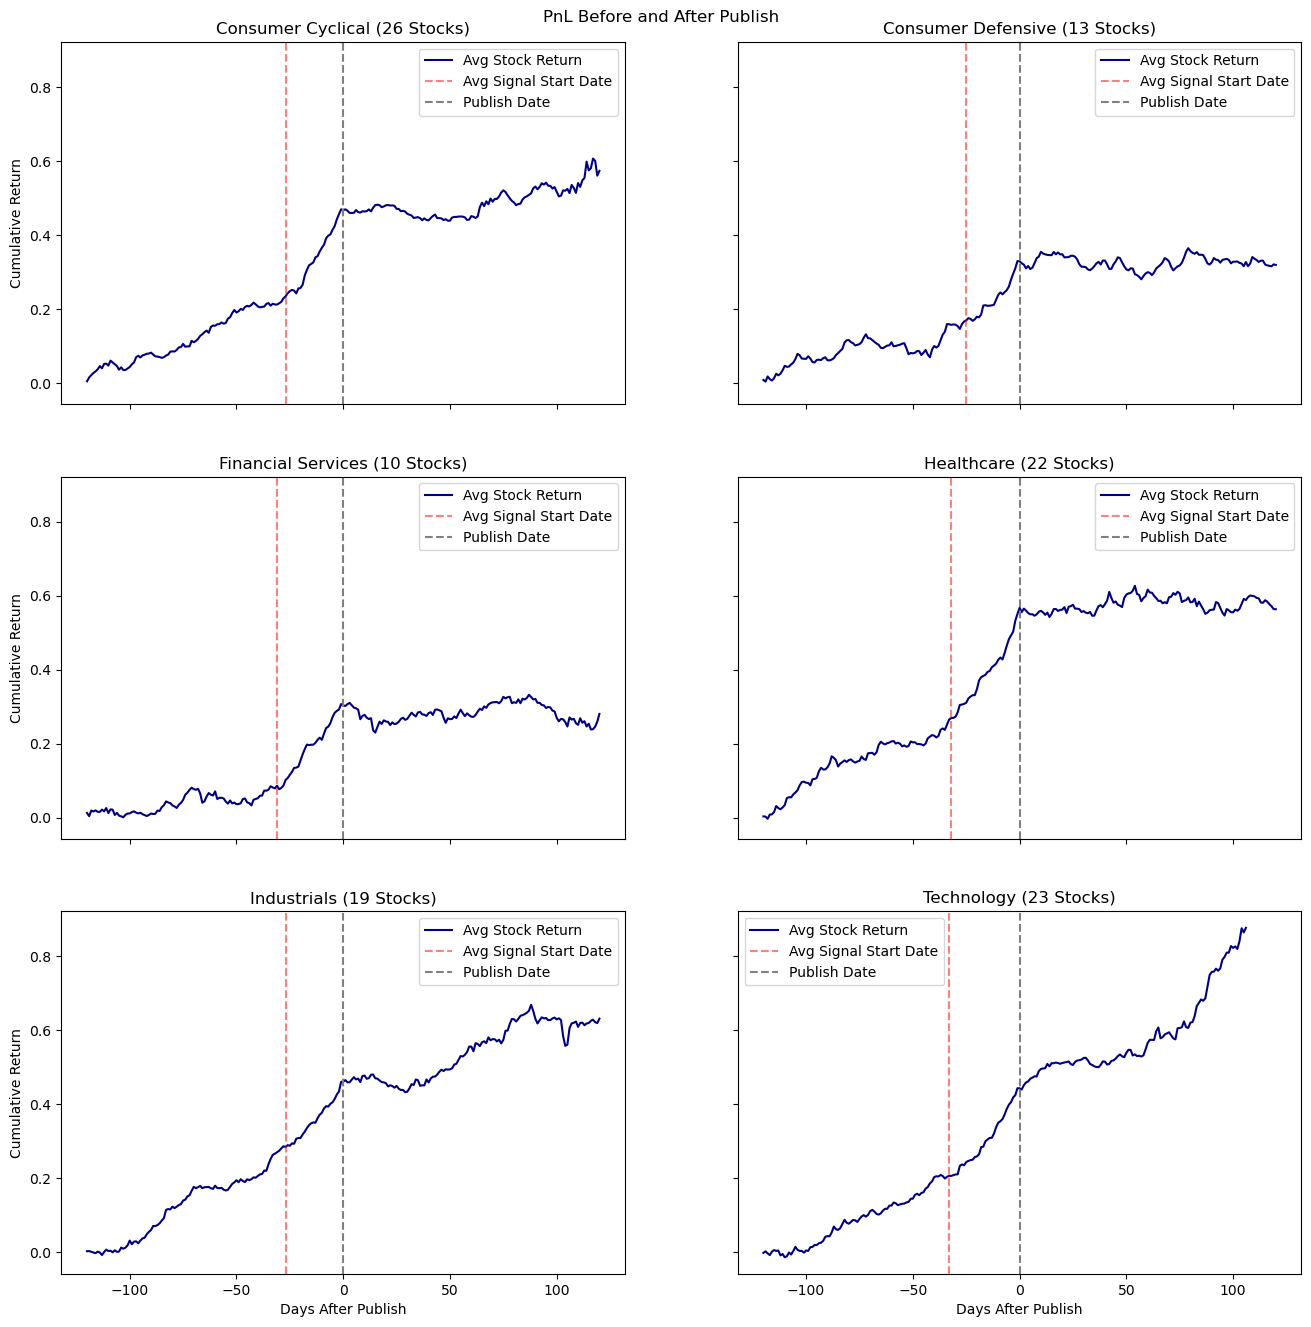

In [12]:
fig,ax=plt.subplots(3,2,figsize=(16,16),sharey=True,sharex=True)

ret_df_label_plot4 = ret_df_label_plot3.groupby(['Sector','Days After Publish'
                                                ])['Return'].mean().groupby('Sector').cumsum().unstack().T

for i in range(len(ret_df_label_plot4.columns)):
    cur_sector = ret_df_label_plot4.columns[i]
    ret_df_label_plot4[cur_sector].plot(ax=ax[i//2,i%2],label='Avg Stock Return',color='navy')
    ax[i//2,i%2].set_title(cur_sector+' ('+str(print_df.loc[print_df['Sector']==cur_sector,'Number of Stocks'].values[0])+' Stocks)')
    ax[i//2,i%2].axvline(x=-round(print_df.loc[print_df['Sector']==cur_sector,'Avg Holding Period'].values[0],0),
                        color='red',label='Avg Signal Start Date',linestyle='--',alpha=0.5)
    ax[i//2,i%2].axvline(x=0,color='gray',label='Publish Date',linestyle='--')
    ax[i//2,i%2].set_ylabel('Cumulative Return')
    ax[i//2,i%2].legend()

plt.suptitle('PnL Before and After Publish',x=0.5,y=0.9)
plt.show()

### Simple Strategy
**This poses an interesting trade proposal: If Chart of the Day suggests a stock from the technology or industrials sector, then we should open a long position of this stock on the publish date and hold it for 30 days.** In this section, we offer a few more metrics to examine the robustness of this strategy.

*Note that in the case where we need to hold multiple stocks, an equally weighted portfolio is constructed, i.e.- the daily return of the strategy is the simple average of the stock returns on the same day. This might imply frequent rebalancing as new stocks are being added to the portfolio, and could potentially incur high slippage costs.*

In [13]:
simple_strat = ret_df_label_plot3.loc[(ret_df_label_plot3['Sector'].isin(['Technology','Industrials']))&
                                      (ret_df_label_plot3['Type']=='After Publishing')&
                                      (ret_df_label_plot3['Days After Publish']<=30)]
simple_strat.head(5)

,Date,Ticker,Return,Type,Days After Signal,Days After Publish,Sector
23670,2022-11-23,EME,-0.007752,After Publishing,31,1,Industrials
23802,2022-11-25,EME,0.011785,After Publishing,32,2,Industrials
23872,2022-11-25,THR,0.005882,After Publishing,23,1,Industrials
23934,2022-11-28,EME,-0.016667,After Publishing,33,3,Industrials
24004,2022-11-28,THR,-0.017057,After Publishing,24,2,Industrials


**A quick overview of the PnL of this strategy tells us that this might be an actionable strategy.** We see that even though the alpha of Trend Seeker significantly decayed after the publishment, there is still certain amount of profit being left on the table, as long as we only add tech or industrials stocks in our trading universe. **As a contrast and a benchmark, we also plot a version of this strategy without the sector filter.** It is not difficult to see that sector filter is an important element for this strategy to work. This is not surprising, given the fact that tech and industrial sectors have been performing very well since November last year. So this strategy's return could very well come largely from the sector outperformance, and probably not from the leftover alpha from Chart of the Day.

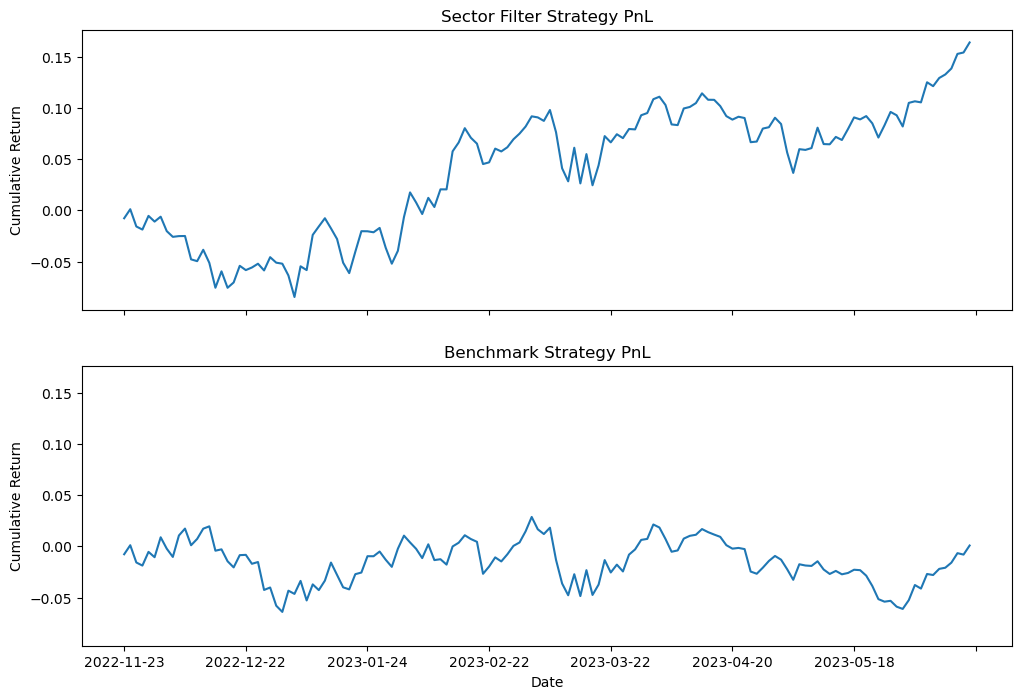

In [14]:
fig,ax = plt.subplots(2,1,figsize=(12,8),sharex=True,sharey=True)

simple_strat.groupby('Date')['Return'].mean().cumsum().plot(ax=ax[0])
ret_df_label_plot3.loc[(ret_df_label_plot3['Type']=='After Publishing')&
                       (ret_df_label_plot3['Days After Publish']<=30)].groupby('Date')['Return'].mean().cumsum().plot(ax=ax[1])

ax[0].set_title('Sector Filter Strategy PnL')
ax[1].set_title('Benchmark Strategy PnL')
ax[0].set_ylabel('Cumulative Return')
ax[1].set_ylabel('Cumulative Return')
plt.show()

**As the last section of this project, we offer a robust measure of the sector filter strategy.** We can see that this strategy has very similar sharpe ratio as the S&P index in the same period, with higher cumulative returns, slightly higher max drawdowns, and higher calmar ratio, which suggests a slightly better risk-adjusted investment vehicle. Note that this sector filter strategy did not take into account for slippage, which could lead to a slightly worse executed performance over the S&P index.

In [15]:
sector_strat = simple_strat.groupby('Date')['Return'].mean().reset_index().rename({'Date':'date',
                                                                                   'Return':'return'},axis=1)
benchmark_strat = ret_df_label_plot3.loc[(ret_df_label_plot3['Type']=='After Publishing')&
                       (ret_df_label_plot3['Days After Publish']<=30)
                                        ].groupby('Date')['Return'].mean().reset_index().rename({'Date':'date',
                                                                                   'Return':'return'},axis=1)
sp500 = yf.download('SPY',start='2022-11-22',
                    end='2023-06-16',progress=False)['Adj Close'].pct_change().dropna().reset_index().rename(
    {'Adj Close':'return','Date':'date'},axis=1)

sector_strat['date'] = pd.to_datetime(sector_strat['date'])
benchmark_strat['date'] = pd.to_datetime(benchmark_strat['date'])
sp500['date'] = pd.to_datetime(sp500['date'])

In [16]:
sector = performance.Trading_Strategy(sector_strat)
sector_metrics = sector.get_metrics().drop('Time in Market')

benchmark = performance.Trading_Strategy(benchmark_strat)
benchmark_metrics = benchmark.get_metrics().drop('Time in Market')

sp = performance.Trading_Strategy(sp500)
sp_metrics = sp.get_metrics().drop('Time in Market')

print(tabulate(pd.concat([sector_metrics,benchmark_metrics,sp_metrics],axis=1),headers=['Sector Filter Strategy',
                                                                                        'Benchmark Strategy',
                                                                                        'S&P 500'],
              tablefmt='rst',stralign='center'))

=====================  ========================  ====================  ==========
         ..             Sector Filter Strategy    Benchmark Strategy    S&P 500
=====================  ========================  ====================  ==========
        From                  2022-11-23              2022-11-23       2022-11-23
         To                   2023-06-15              2023-06-15       2023-06-15
  Annualized Sharpe            1.31078                  0.0078          1.32266
 Annualized Sortino            2.08362                 0.01169          2.23946
  Cumulative Return            0.16374                 0.00078          0.11685
     Avg Return                0.00117                  1e-05           0.00083
       Avg Win                 0.01178                 0.00895          0.00834
      Avg Loss                 -0.01006                -0.00894         -0.00734
      Win Ratio                0.51429                   0.5            0.52143
     Max Winner                